In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
sns.set()
%matplotlib inline
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords');

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liliyajeromin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Questions:
1. Where to earn money and where to live?
2. Is the prices differentiate depending on location?
3. Does size matter?
4. What else affect the price?
5. What is really matters to your guests?

In [2]:
#handy method to make all columns with currency into float
def money_laundry(df):
    '''
    Turning currency columns from type object into calculable type float.
    
    INPUT:
    df - pandas dataframe with currency columns which you want to turn into float.
    col_list - predifined list of columns that could be changed.
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. all currency columns cleanded from $ sign and comma devider.
            2. column has the type float.
         
    '''
    
    col_list = ('price', 'cleaning_fee', 'extra_people')
    for col in col_list:
        try:
            df[col] = df[col].str.replace('$', '')
            df[col] = df[col].str.replace(',', '')
            df[col] = df[col].astype(float)
        except:
            print ('Ooops, this column either doesnt exist or already has been cleaned')        
    return df

In [3]:
#handy method to remove columns
def remove_col (df, cols):
    '''
    Romoves list of columns (cols) you don't need from the df.
    
    INPUT:
    df - pandas dataframe from which you want to delete columns.
    cols - list of strings that are associated with names of columns you want to delete.
    
    OUTPUT:
    df - a new dataframe without columns you deleted.
          
    '''
    for col in cols:
        df = df.drop(columns=col, axis=1)
    return df

In [4]:
#handy method categorical variables to dummies
def cat_var(df):
    '''
    Turning categorical variables into dummies.
    
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy.
    cat_vars - list of strings that are associated with names of the categorical columns.
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical.
            2. removes all the original columns in cat_vars.
            3. dummy columns for each of the categorical columns in cat_vars.
            4. Use a prefix of the column name with an underscore (_) for separating. 
    '''
    
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    return df

In [5]:
#filling NaNs
def num_var(df):
    '''
    Filling nulls with means of a column.
    
    INPUT:
    df - pandas dataframe with numerical columns you want to fill nulls into.
    num_vars - list of strings that are associated with names of the numerical columns.
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that are not numerical.
            2. contains all columns that didn't have NaNs.
            3. contains columns that had NaNs wit means instead .
    '''
    
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
    
    return df

## 1. Where to earn money and where to live?

In [6]:
#read and clean function for calendar
def read_clean_calendar(file_path):
    '''
    Preparing the calendar data sets for comparing with each other.
    
    INPUT:
    file_path - a string with the path to the calendar file.
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains no columns with nulls in it.
            2. contains no columns with the same values all for all entries.
            3. columns with currency cleaned and has the type float.
            4. contains a new column with month value, extraxted from the data column.
        
    '''
    #read a file
    df = pd.read_csv(file_path)
    
    #get rid of NaNs
    df = df.dropna(axis=0)
    
    #drop the column with the same value for all indexes
    df = df.drop(columns=['available'], axis=1)
    
    money_laundry(df)
    
    #extract months
    df['month'] = pd.DatetimeIndex(df['date']).month
    
    return df

In [7]:
boston = read_clean_calendar('boston/calendar.csv')
seattle = read_clean_calendar('seattle/calendar.csv')

Ooops, this column either doesnt exist or already has been cleaned
Ooops, this column either doesnt exist or already has been cleaned
Ooops, this column either doesnt exist or already has been cleaned
Ooops, this column either doesnt exist or already has been cleaned


In [8]:
def plot_cals (boston, seattle):
    '''
    Plots the compare table of two calendar data sets.
    
    INPUT:
    boston - prepared and cleaned calendar set of Boston.
    seattle - prepared and cleaned calendar set of Seattle.
    
    OUTPUT:
    plot - a plot that shows changes of average prices in Boston and Seattle separetly depending on months
          
    '''
    #make one table with mean of price per month
    compare_table = pd.DataFrame()
    compare_table['Prices Seattle'] = seattle.groupby('month')['price'].mean()
    compare_table['Prices Boston'] = boston.groupby('month')['price'].mean()
    
    #plot it
    compare_table.plot(figsize=(12,8), title='Compare prices for accomodation in Seattle and Boston per month, $', xticks=(1,2,3,4,5,6,7,8,9,10,11,12))
    #plt.savefig('BostonVSSeattle.png')

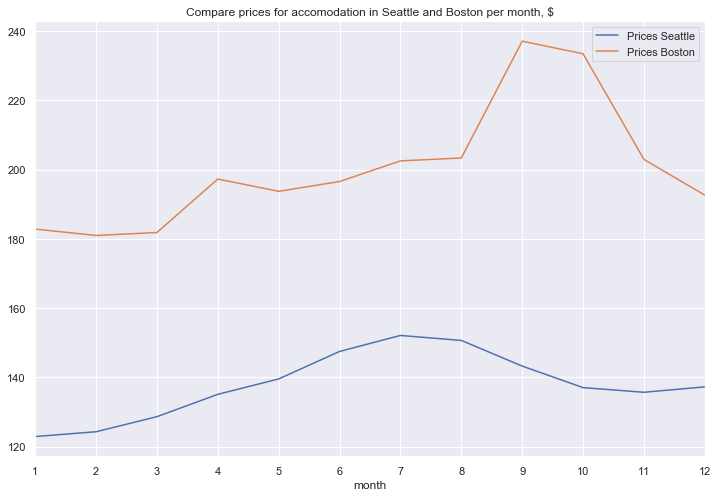

In [9]:
plot_cals (boston, seattle)

## 2. Where exactly in Boston

In [10]:
def get_price_location():
    '''
    Plotting a location-price dependency.
    
    INPUT:
    df - as the df stays the same it is read inside the method.
    
    OUTPUT:
    plot - a bar plot showing prices depending on location.
    '''
    #read the boston listing file
    df = pd.read_csv('boston/listings.csv')
    
    #clean price column and get float
    money_laundry(df)
    
    #get prices for each location
    price_location = df.groupby(['neighbourhood_cleansed'])['price'].mean().sort_values(ascending=False)
    #print (price_location)
    
    #plot it
    price_location.plot.bar(figsize=(13,10), title = 'Prices for accomodations in Boston depending on locations, $')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=16)
    plt.ylabel('Avg. prices per night in $', fontsize=16)
    #plt.savefig('prices_location.png')

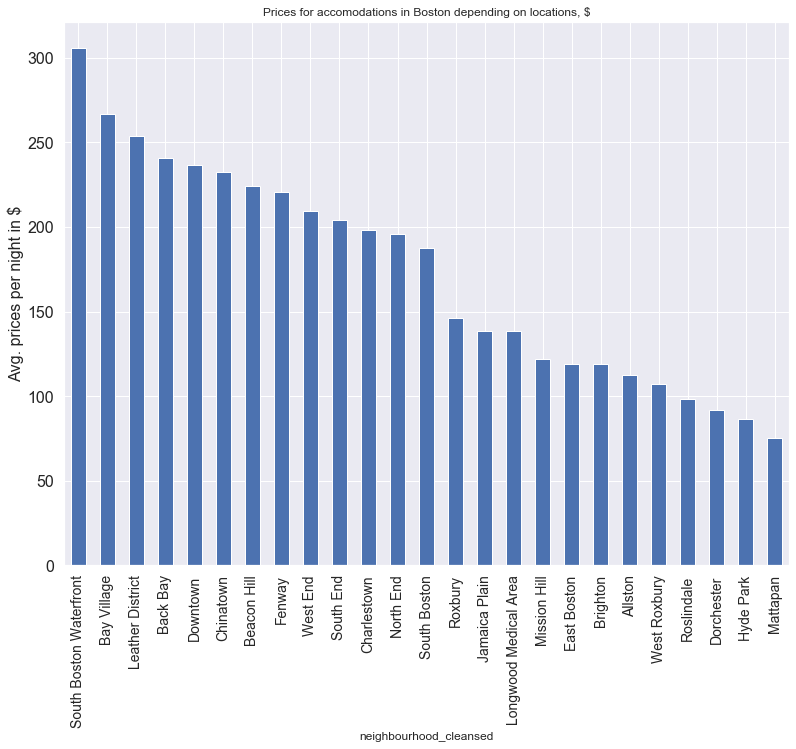

In [11]:
get_price_location()

## 3. Does size matter?

In [14]:
def size_matters():
    '''
    PLotting a heatmap of correlatons between price and some variables that inderectly shows the size of the apartment.
    
    INPUT:
    df is read inside the methos as it stays unchanged.
    df has following charachteristics:
            1. contains only columns that are defined as to be of matter for a size of apartement.
            2. contains the price column in type float.
            3. contains numerical columns without any NaNs.
            4. contains categorical columns converted into dummies.
   
    
    OUTPUT:
    heatmap showing correlations of all variables to each other
    
    '''
     #read the boston listing file
    df = pd.read_csv('boston/listings.csv')
    
    #get columns we need
    df = df[['price','bedrooms', 'beds', 'bathrooms', 'room_type', 'property_type', 'accommodates']]
 
    #clean price column and get float
    df = money_laundry(df)
    
    #fill means instead of NaNs for numeric columns  
    df = num_var(df)
    
    #dummies for categorical columns
    df = cat_var(df)
    
    #heatmap
    matrix = np.triu(df.corr())
    ax = sns.heatmap(df.corr(), annot = True, mask=matrix);
    ax.set_ylim(len(matrix), 0);
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax = sns.set(rc={'figure.figsize':(19,19)});
    #plt.savefig('size_matters.png')

Ooops, this column either doesnt exist or already has been cleaned
Ooops, this column either doesnt exist or already has been cleaned


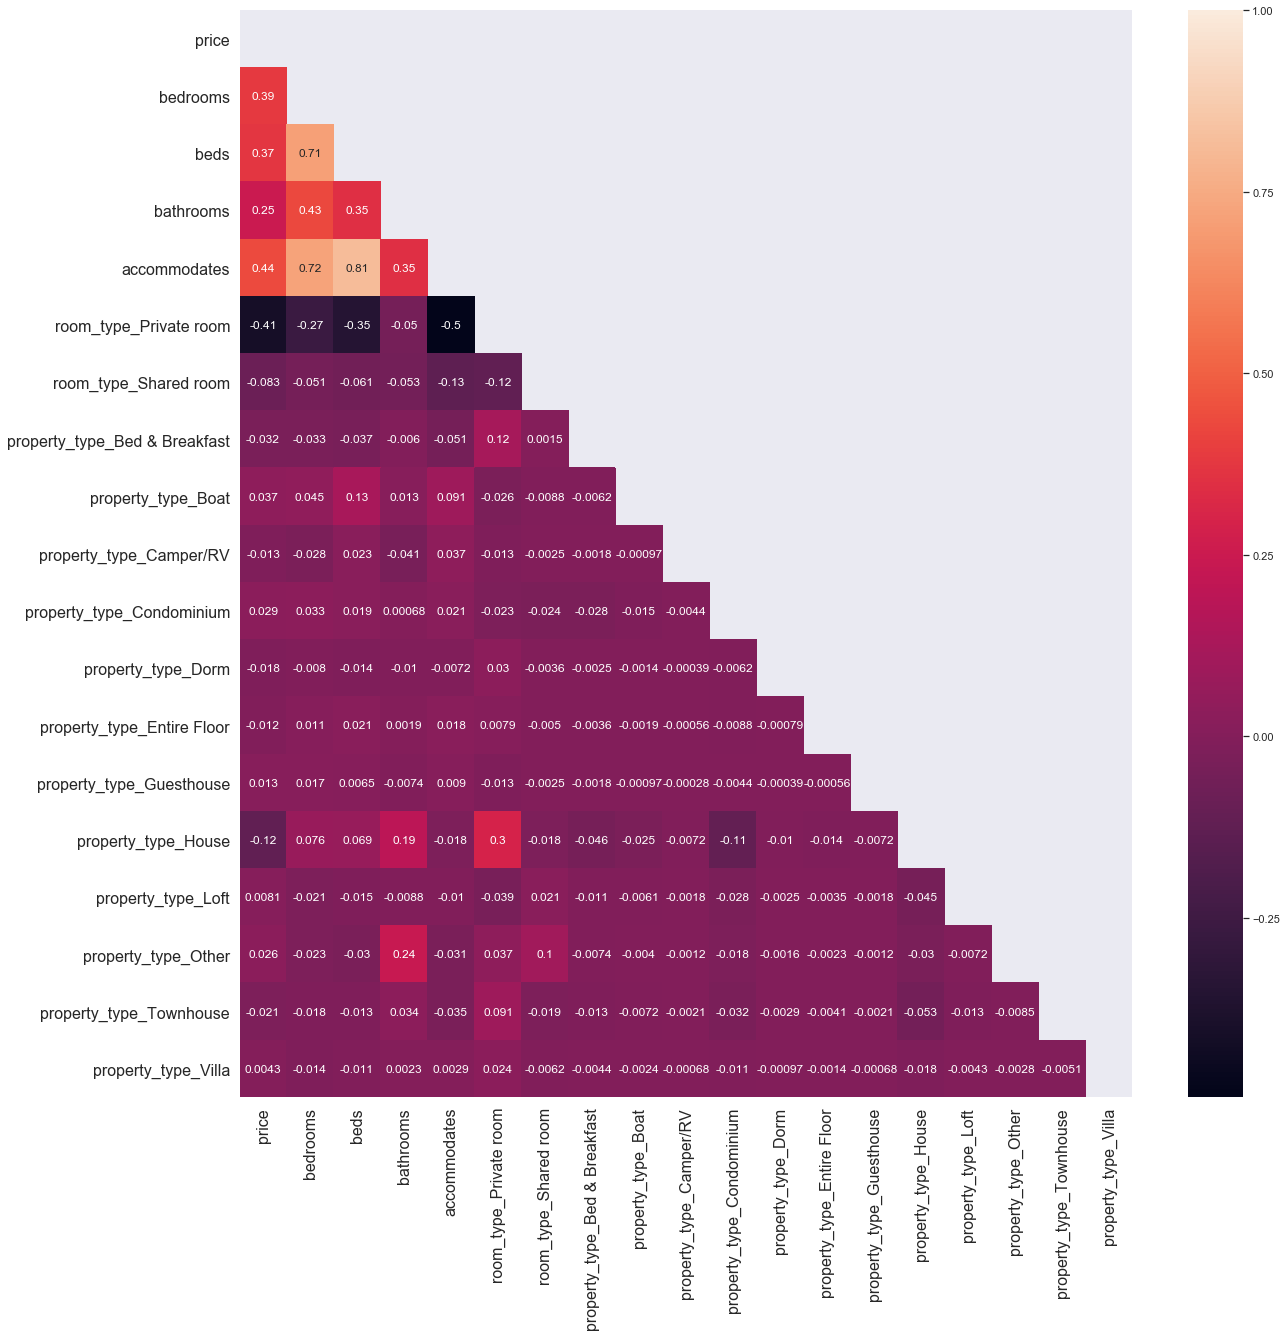

In [15]:
size_matters()

## 4. What else affect the price?

In [12]:
def clean_data(df):
    '''
    Prepearing data for a regression analyse.
    
    INPUT:
    df - pandas dataframe with all columns.
    
    col_missing_value - list of strings that are associated with names of the columns which have more then 50% NaNs (defined inside the method)
    col_no_need - list of strings that are associated with names of the categorical columns turning which to dummies makes no sence or delivers too many columns.
    
    
    OUTPUT:
    X - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical.
            2. removes all the original columns listed in col_missing_value.
            3. removes all the original columns listed in col_no_need.
            4. contains all currency columns cleaned and in type float. 
            5. dummy columns for each of the categorical columns in df.
            6. if dummy_na is True - it also contains dummy columns for the NaN values.
            7. use a prefix of the column name with an underscore (_) for separating.
            8. removes the column price.
            
    y - a new data frame that has only one column 'price', wich is cleaned and turned into float type.
    
    '''
    # #drop columns with more then 50 NaN
    col_missing_value = df.columns[df.isnull().mean() >= 0.5]  
    df = remove_col(df, col_missing_value)
    
     #drop columns with much text and no possibility to make dummies    
    col_no_need = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name','summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview', 'transit', 'access', 
        'interaction', 'house_rules','thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 
        'host_id', 'host_url', 'host_name', 'host_since','host_about','host_thumbnail_url', 'host_picture_url',
        'host_neighbourhood','host_verifications', 'street', 'neighbourhood',
        'smart_location', 'country', 'city', 'state', 'zipcode', 
        'market','calendar_updated','calendar_last_scraped',
        'first_review', 'last_review', 'amenities', 'host_location', 'host_total_listings_count', 
        'host_listings_count', 'minimum_nights', 'guests_included',  'maximum_nights'] 
    df = remove_col(df, col_no_need)
    
    #make columns with currency to floats
    df = money_laundry(df)
    
    #set dependable variable
    y = df['price']
    
     #make columns with % float 0-1
    percent_to_float = ('host_response_rate', 'host_acceptance_rate')
    for item in percent_to_float:
        df[item] = df[item].str.replace('%', '')
        df[item] = df[item].astype(float)
        df[item] = df[item]/100
    
    #remove price from df
    df = df.drop(columns=['price'], axis=1)
    
    df = num_var(df)
    
    df = cat_var(df)
    
    X = df
    
    return X, y

In [13]:
df = pd.read_csv('boston/listings.csv')
X, y = clean_data(df)

In [18]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

#Instantiate
lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) #Fit
        
#Predict the model
y_test_preds = lm_model.predict(X_test) 

#score the model
rsquared_score = r2_score(y_test, y_test_preds)
length_y_test = len(y_test)

"The r-squared score for your model was {} on {} values.".format(rsquared_score, length_y_test)

'The r-squared score for your model was 0.3011466325172737 on 1076 values.'

In [19]:
def coef_weights(coefficients, X_train):
    '''
    Calculated weghts of coefficients and outs it into a table.
    
    INPUT:
    coefficients - coefficients of the regression model which are taken from lm_model.
    X_train - part of the datas which are used for training in the model.
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains a column with names of features from the train part of X data frame.
            2. contains a column with coefficients or weights in the regression for each feature
            3. contains a colimn with absolut weghts for each feature.
            4. is sorted by absolut coefficients from the higher to lower 
            
    '''
    
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False).reset_index()
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(40)

,index,est_int,coefs,abs_coefs
0,3,longitude,819.309940,819.309940
1,2,latitude,309.395809,309.395809
2,57,property_type_Camper/RV,-162.163852,162.163852
3,76,cancellation_policy_super_strict_30,110.198154,110.198154
4,38,neighbourhood_cleansed_East Boston,-91.284256,91.284256
5,50,neighbourhood_cleansed_South Boston Waterfront,75.354336,75.354336
6,68,room_type_Shared room,-66.534260,66.534260
7,36,neighbourhood_cleansed_Dorchester,-60.618250,60.618250
8,30,neighbourhood_cleansed_Back Bay,59.129682,59.129682
9,44,neighbourhood_cleansed_Mattapan,-52.700039,52.700039


## 4. What is really matters to the guests?

In [20]:
def get_idea_reviews():
    '''
    Gets words from reviews, separates them, calculates the number of using that words and plot the result of first 30 words. 
    
    INPUT:
    all inputs are inside the method as they mean to stay unchangable.

    
    OUTPUT:
    
    plot of a bar plot based on data from reviews_30.
    reviews_30 - a new dataframe that has the following characteristics:
                1. is read from boston reviews file
                2. removes all nulls
                3. gets only one column - 'comments'
                4. clears this from punctuation marks
                5. splits each word separately
                6. makes a list of words
                7. removes stop words
                8. removes words that dont has any meaning for the analysis
                9. makes all words to lowcase
                10. counts how often comes each word
                11. takes only 30 firts entries
    
    Plotts them
             
    '''
    #read the file
    df = pd.read_csv('boston/reviews.csv')
    
    #drop nan in comments
    df = df.dropna()
    
    #we need only words
    reviews_str = ' '.join(df['comments'])
    reviews_str = reviews_str.replace('.', '')
    reviews_str = reviews_str.replace(',', '')
    reviews_str = reviews_str.replace('!', '')
    words = reviews_str.split(' ')
    
    
    #cleaning stop words and words that doesn't mean anything for our research
    stopwords_english = stopwords.words('english')
    words_no_meaning = ['great','airbnb', '&', 'could', 'everything', 'definitely', 'de', 'la', 'well', 'also', 'made', 'stay', 'would', 'us', 'boston', 'really', 'recommend', 'boston.', '-', 'even', 'like', 'one']
    
    #make all words to lowcase and delete words we don't need
    words_without_stopwords = [word.lower() for word in words if word.lower() not in stopwords_english and word.strip() != '']
    words_without_wnm = [word for word in words_without_stopwords if word not in words_no_meaning and word.strip() != '']
    
    #count the words
    reviews_word_series = pd.Series(words_without_wnm)
    reviews_word_series_counts = reviews_word_series.value_counts()
    
    #take upper 50
    reviews_30 = reviews_word_series_counts[0:30]
    
    #plot that
    plt.figure(figsize=(18,10))
    plt.bar(reviews_30.index, reviews_30)
    plt.xticks(rotation=90, fontsize=18)
    plt.yticks(fontsize=14)
    plt.xlabel('words', fontsize=16)
    plt.ylabel('frequency', fontsize=16)
    #plt.savefig('words_wo_great.png');
    plt.show();
    

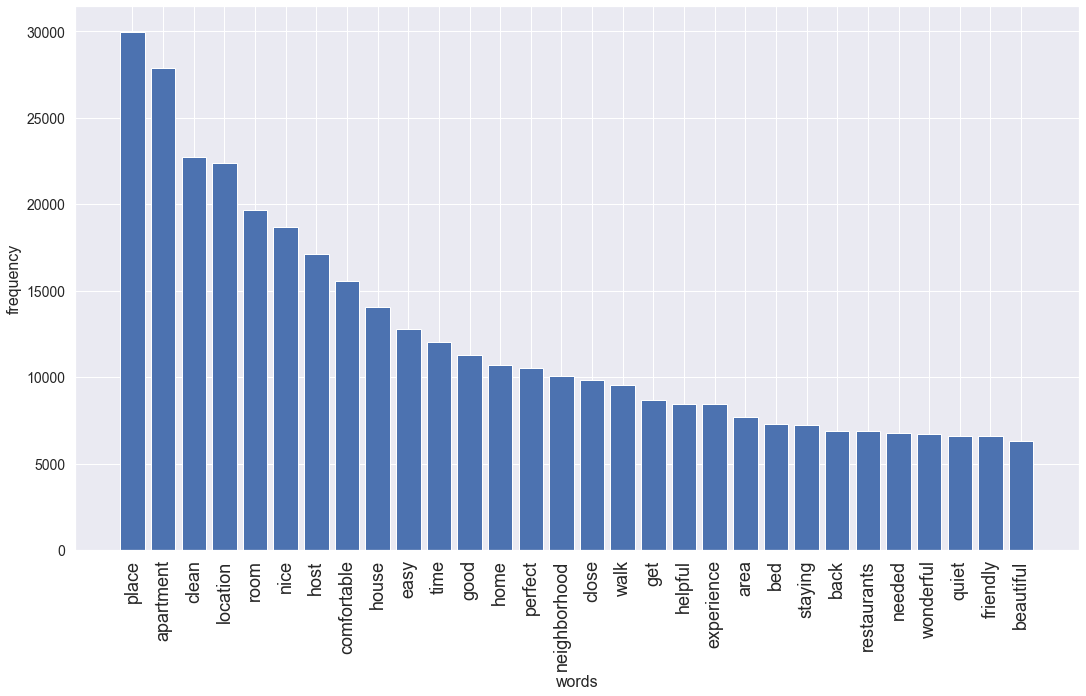

In [21]:
get_idea_reviews()